# Visualizing data
In this lesson we will look at example code for comparing differences in two indpendent data sets and look at corrlation for paired data. We will use matplotlib for plotting data and scipy for statistical analysis

# Install libaries 
Only needed if you do not already have pandas, matplotlib and scipy

In [ ]:
%pip install pandas
%pip install scipy
%pip install matplotlib

# Histograms

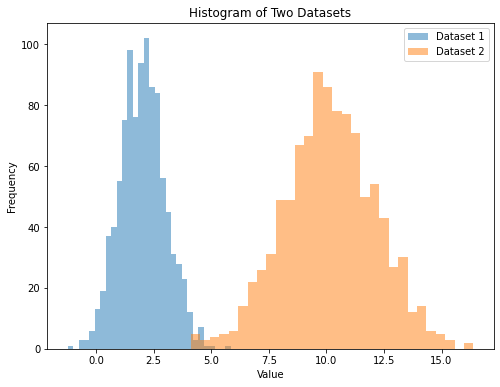

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#load csv with example data
df = pd.read_csv("two_datasets_example.csv")

# Extract columns
data1 = df.iloc[:, 0]
data2 = df.iloc[:, 1]

# Plot histograms
plt.figure(figsize=(8, 6))

plt.hist(data1, bins=30, alpha=0.5, label='Dataset 1')
plt.hist(data2, bins=30, alpha=0.5, label='Dataset 2')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Two Datasets")
plt.legend()

plt.show()
#note plots can also be saved to a file using plt.savefig('FILENAME.EXTENSION'), the extension can be image files such as png
#or pdf for a pdf version

# Plottng multiple graphs
We will can also plot the histograms shown above in multiple graphs

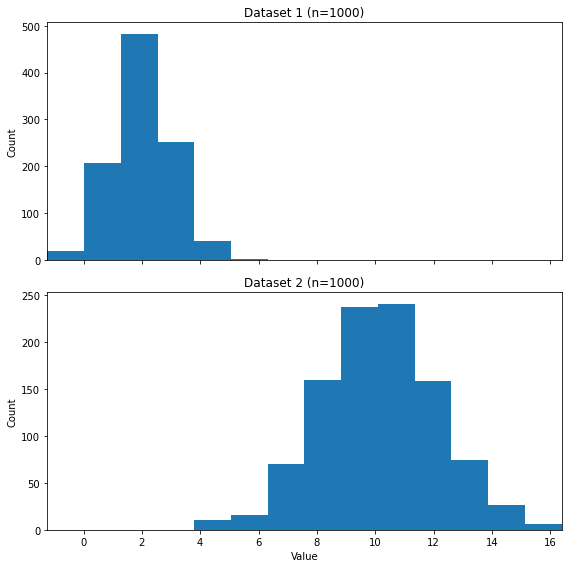

In [5]:
import numpy as np

combined = np.concatenate([data1, data2])

# Use numpy's automatic bin rule (or set a fixed number like bins=30)
bins = np.histogram_bin_edges(combined, bins="auto")

#get the min and max values over both datsets
xmin, xmax = combined.min(), combined.max()

#creates a figure with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

#note we can use plt for single graphs, but here we will use axs[i] where i is the subgraph we want to plot on
axs[0].hist(data1, bins=bins)
axs[0].set_title(f"Dataset 1 (n={len(data1)})")
axs[0].set_ylabel("Count")
axs[0].set_xlim(xmin, xmax)

axs[1].hist(data2, bins=bins)
axs[1].set_title(f"Dataset 2 (n={len(data2)})")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Count")
axs[1].set_xlim(xmin, xmax)

plt.tight_layout()
plt.show()

# Statistical tests - normality
We first want to test if our datasets are normally distributed - this will tell us if we can use tests that assume normal distributions
<br/>
Scipy offers multiple tests including the Shapiro-Wilk (better for smaller datasets), D'Agostino-Pearson (better for larger datasets). If p < 0.05 it means that the distribution is significantly deviated from normal and you should not use a test that rquires normality.

In [8]:
#import statistical tests
from scipy.stats import shapiro, normaltest, levene

#Shapiro-Wilk dataset, better for smaller datasets
W, p = shapiro(data1)
print(f"Dataset 1 Shapiro-Wilk: W={W:.4g}, p={p:.4g}")

W, p = shapiro(data2)
print(f"Dataset 2 Shapiro-Wilk: W={W:.4g}, p={p:.4g}")

#D'Agostino-Pearson dataset, better for larger datasets
stat, p = normaltest(data1)
print(f"Dataset 1 D’Agostino-Pearson: stat={stat:.4g}, p={p:.4g}")

stat, p = normaltest(data2)
print(f"Dataset 2 D’Agostino-Pearson: stat={stat:.4g}, p={p:.4g}")

#calculate variance of each sample - important to know what t test to use
var_1_sample = data1.var()
print(f"Variance of Dataset 1: {var_1_sample}")
var_2_sample = data2.var()
print(f"Variance of Dataset 2: {var_2_sample}")

#levene test will test if these variances are statistically signifcantly different (significantly different if p <0.05)
lev_stat, lev_p = levene(data1, data2)
print(f"Levene (equal variances): stat={lev_stat:.4g}, p={lev_p:.4g}")


Dataset 1 Shapiro-Wilk: W=0.9986, p=0.6265
Dataset 2 Shapiro-Wilk: W=0.9988, p=0.7315
Dataset 1 D’Agostino-Pearson: stat=2.576, p=0.2759
Dataset 2 D’Agostino-Pearson: stat=0.6094, p=0.7373
Variance of Dataset 1: 0.9588638535851022
Variance of Dataset 2: 3.9796609386005666
Levene (equal variances): stat=350.4, p=3.554e-72


# Statistical tests - comparing distributions
Since we determined based on the previous tests that our distribution does not show significant deviation from normal, we can use tests that assume normality, such as the t test. It is best to use these tests if you can since they have more power, but we will also look at some other example comparison datasets that work for data that is not normally distributed

In [9]:
from scipy.stats import ks_2samp, mannwhitneyu, ttest_ind

#non-parametric tests that do not assume normal distribution
#Kolmogorov-Smirnov - tests if two samples come from the same distribution
ks_stat, ks_p = ks_2samp(data1, data2)
print(f"KS test: D={ks_stat:.4g}, p={ks_p:.4g}")

#tests null hypothesis that distributions are identical
u_stat, u_p = mannwhitneyu(data1, data2, alternative="two-sided")
print(f"Mann–Whitney U: U={u_stat:.4g}, p={u_p:.4g}")

#t test that does assume normal distribution
#Welch's t test - does not assume variance is equal, which is the case for our data
#to do a student's t test if the variances are know to be equal, set equal_var=True
t_stat, t_p = ttest_ind(data1, data2, equal_var=False)
print(f"Welch t-test: t={t_stat:.4g}, p={t_p:.4g}")


KS test: D=0.992, p=0
Mann–Whitney U: U=93, p=0
Welch t-test: t=-115.6, p=0


# Bargraphs

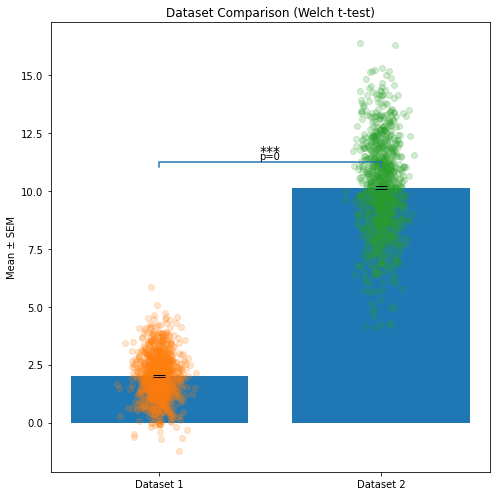

In [23]:
def p_to_stars(pval: float) -> str:
    if pval < 0.0005:
        return "***"
    elif pval < 0.005:
        return "**"
    elif pval < 0.05:
        return "*"
    else:
        return "ns"
    
#figure out how many stars we should put above the bar's based on the Welch's t test p value
stars = p_to_stars(t_p)

#calculate mean and standard error
means = np.array([data1.mean(), data2.mean()])
sems  = np.array([data1.std(ddof=1)/np.sqrt(len(data1)), data2.std(ddof=1)/np.sqrt(len(data2))])

#make bar graph
fig, ax = plt.subplots(figsize=(7, 7))
labels = ["Dataset 1", "Dataset 2"]
xpos = np.arange(len(labels))
ax.bar(xpos, means, yerr=sems, capsize=6)
ax.set_xticks(xpos)
ax.set_xticklabels(labels)
ax.set_ylabel("Mean ± SEM")
ax.set_title("Dataset Comparison (Welch t-test)")

#Overlay data points over bars
# Add slight horizontal jitter for visibility
jitter_strength = 0.05

#zorder specifies that the points should be drawn over the bar grao
#alpha sets opacity, making the points transparent means we can see the bars
ax.scatter(np.full_like(data1, xpos[0]) + np.random.normal(0, jitter_strength, len(data1)), data1, zorder=2,alpha=0.2)
ax.scatter(np.full_like(data2, xpos[1]) + np.random.normal(0, jitter_strength, len(data2)), data2, zorder=2,alpha=0.2)

#add significance indication
# Place bracket a little above the tallest bar+SEM
y_top = (means + sems).max()
h = y_top * 0.08 if y_top != 0 else 0.1   # bracket height
y_bracket = y_top + h

# Bracket coordinates: left, right
x1, x2 = xpos[0], xpos[1]
ax.plot([x1, x1, x2, x2],
        [y_bracket, y_bracket + h*0.25, y_bracket + h*0.25, y_bracket],
        linewidth=1.5)

# Stars text centered over bracket
ax.text((x1 + x2) / 2, y_bracket + h*0.5, stars, ha="center", va="bottom", fontsize=14)

# Optional: annotate p-value
ax.text((x1 + x2) / 2, y_bracket + h*0.3, f"p={t_p:.3g}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# Scatter plot

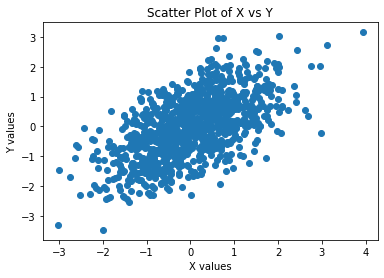

In [24]:
# Load the CSV file
df = pd.read_csv("correlation_dataset.csv")

# Extract columns
x = df["x"]
y = df["y"]

# Create scatter plot
plt.figure()
plt.scatter(x, y)

# Add labels
plt.xlabel("X values")
plt.ylabel("Y values")
plt.title("Scatter Plot of X vs Y")

# Show plot
plt.show()

# Calculate Correlation
We will calculate two types of correlation, pearson's which measures correlation of the data itself and spearmans which looks at the correlation of the rank of the data - both x and y data is ranked and then the correlation between those ranks is calculated. Spearman's is a better measure if correlation is not linear. Correlation can be positive or negative, magnitudes range from 0 to 1. Magnitude gives the strength of a correlation for example 0.4 to 0.6 is moderate corrlation, 0.6 to 0.8 is strong correlation, and 0.8 to 1 is very strong correlation. These tests also give a p-value which is a measure of the statistical significance of the correlation. Weak or moderate correlations can be statistically significant if there are enough data points, but this should not be considered stronger correlation than smaller datasets with higher magnitudes of correlation but higher p values.

In [27]:
from scipy.stats import pearsonr, spearmanr

# Pearson
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson correlation: {pearson_corr}")
print(f"Pearson p-value: {pearson_p}")

print(f"Spearman correlation: {spearman_corr}")
print(f"Spearman p-value: {spearman_p}")

Pearson correlation: 0.5947730113730303
Pearson p-value: 1.03597082054438e-96
Spearman correlation: 0.5785219825219826
Spearman p-value: 2.132273514883208e-90


# Linear regression
We can also fit a linear regression for this data and get an r-squared and p-value. We can then plot the data along with the regression.

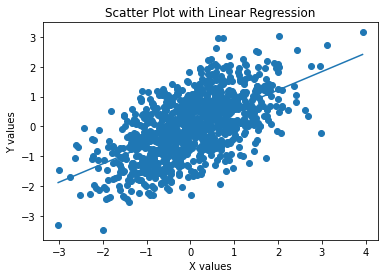

Slope: 0.6180359260883107
Intercept: -0.015080599691933589
R-squared: 0.35375493505774297
P-value: 1.0359708205444185e-96


In [28]:
from scipy.stats import linregress

# Fit linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Generate regression line values
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept

# Plot
plt.figure()
plt.scatter(x, y)
plt.plot(x_line, y_line)

plt.xlabel("X values")
plt.ylabel("Y values")
plt.title("Scatter Plot with Linear Regression")

plt.show()

# Print regression statistics
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")